# Data Preprocessing

**Data Preprocessing** is the initial phase of a Machine Learning project in which raw data is transformed into a cleaner, more consistent format suitable for analysis or model training. We've already prepared the data for splitting, avoiding inconsistencies and data leakage. Now let's do the rest of the Preprocessing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import warnings

from CogniPredictAD.preprocessing import ADNICleaner, ADNITransformator, OutlierDetector
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="No artists with labels found to put in legend.*")
warnings.filterwarnings("ignore", message="Duplicate values are leading to incorrect results")

pd.set_option('display.max_rows', 116)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_info_columns', 50) 

train = pd.read_csv("../data/pretrain.csv")
test = pd.read_csv("../data/pretest.csv")

## Data Cleaning

**Data Cleaning** is the first step of Preprocessing and it is used for detecting and correcting or removing errors and inconsistencies in the dataset to improve data quality and model performance. Clean data ensures that the model learns from accurate, relevant, and reliable inputs. 

In [2]:
train_cleaner = ADNICleaner(train)
test_cleaner = ADNICleaner(test)

**ADNICleaner** is a utility class for *Data Cleaning* and *Preprocessing* of the ***ADNIMERGE*** dataset. It stores a DataFrame and provides a collection of data-cleaning utilities tailored for baseline visit selection, missing-value handling, column consolidation, and dataset simplification

### Handling Missing Values

Calculates the percentage of having Null values in each column and prints in descending order.

In [3]:
print("Percentage of NULL values per column:")
null_percent = (train.isna().sum() / len(train) * 100).sort_values(ascending=False)
print(null_percent.apply(lambda x: f"{x:.2f}%"))

Percentage of NULL values per column:
ABETA                    50.10%
TAU                      50.10%
PTAU                     50.10%
FDG                      37.69%
EcogSPOrgan              34.28%
EcogSPVisspat            33.25%
EcogSPDivatt             33.20%
EcogPtOrgan              32.83%
EcogSPPlan               32.83%
EcogSPMem                32.63%
MOCA                     32.57%
EcogSPTotal              32.57%
EcogSPLang               32.52%
EcogPtVisspat            32.37%
EcogPtDivatt             32.16%
EcogPtLang               31.95%
EcogPtPlan               31.95%
EcogPtMem                31.90%
EcogPtTotal              31.90%
MidTemp                  13.08%
Fusiform                 13.08%
Entorhinal               13.08%
Hippocampus              10.75%
APOE4                     8.79%
Ventricles                5.69%
WholeBrain                4.55%
ICV                       3.05%
TRABSCOR                  1.50%
FAQ                       0.93%
ADAS13                    0.47%
RA

We want to use the **K-Nearest Neighbors** (KNN) to impute the NULL values, but there is a problem. The “pure” NumPy np.int64 type cannot contain NaNs. This is because NaN is a special value of the floating point type (float), not integers. sklearn.impute.KNNImputer works on NumPy arrays (np.float64 or real np.int64). Pandas' pd.Int64Dtype() is not an np.int64, it is an extension (ExtensionDtype) that internally represents the data as an array of ints + a Boolean mask for the NAs. When you pass a DataFrame with nullable Int64s to scikit-learn, it tries to convert it to NumPy, and since pd.NA is not a number, it converts it to an object, and KNNImputer cannot work on objects. So we take the columns that are integers, leave them floats, run KNN through them, and then convert them to integers.

In [4]:
int_columns = [
    col for col in train.select_dtypes(include=['float']).columns
    if (train[col].dropna() % 1 == 0).all()
]

# We also add the columns already of type int
int_columns += list(train.select_dtypes(include=['int']).columns)

print("Columns with only integer values:")
print(int_columns)


Columns with only integer values:
['APOE4', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'MOCA', 'PTGENDER', 'PTEDUCAT', 'PTDEMOGROUP', 'MARRIED']


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934 entries, 0 to 1933
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DX                     1934 non-null   object 
 1   AGE                    1932 non-null   float64
 2   PTGENDER               1934 non-null   int64  
 3   PTEDUCAT               1934 non-null   int64  
 4   APOE4                  1764 non-null   float64
 5   CDRSB                  1934 non-null   float64
 6   ADAS11                 1928 non-null   float64
 7   ADAS13                 1925 non-null   float64
 8   ADASQ4                 1931 non-null   float64
 9   MMSE                   1933 non-null   float64
 10  RAVLT_immediate        1931 non-null   float64
 11  RAVLT_learning         1931 non-null   float64
 12  RAVLT_forgetting       1930 non-null   float64
 13  RAVLT_perc_forgetting  1926 non-null   float64
 14  LDELTOTAL              1932 non-null   float64
 15  TRAB

We use a K-Nearest Neighbors imputer to replace NULL values with the most likely values. Let's set k = 5.

In [6]:
# Utility function: impute a group using a KNN fitted on train and applied to test
def knn_impute_group(train_df: pd.DataFrame, test_df: pd.DataFrame, cols: list, n_neighbors: int = 5):
    """
    Fit a KNNImputer on train_df[cols] after scaling (train mean/std),
    transform both train and test for these cols, and replace the values in-place.

    Steps:
      1. Keep only columns present in train_df.
      2. Coerce non-numeric values to NaN (safe conversion).
      3. Compute train mean/std ignoring NaNs (nan-aware).
      4. Standardize train and test using train statistics.
      5. Fit KNNImputer on scaled train and transform both train and test.
      6. Inverse-scale imputed results back to the original scale.
      7. Put imputed columns back into the original DataFrames preserving indices.

    Returns:
      (knn_imputer_object, means_array, stds_array) or (None, None, None) if no cols.
    """
    # keep only columns that actually exist in train_df
    cols = [c for c in cols if c in train_df.columns]
    if len(cols) == 0:
        return None, None, None

    # Coerce to numeric: non-convertible values become NaN
    # Use copy() to avoid modifying original slices unexpectedly
    train_block = train_df[cols].apply(pd.to_numeric, errors="coerce").astype(float).copy()
    test_block = test_df[cols].apply(pd.to_numeric, errors="coerce").astype(float).copy()

    # Compute mean/std on train, ignoring NaNs
    means = np.nanmean(train_block.values, axis=0)
    stds = np.nanstd(train_block.values, axis=0)
    # Prevent division by zero for constant columns
    stds[stds == 0] = 1.0

    # Standardize (nan-aware)
    train_scaled = (train_block.values - means) / stds
    test_scaled = (test_block.values - means) / stds

    # Fit KNNImputer on scaled train and transform both train and test
    knn = KNNImputer(n_neighbors=n_neighbors)
    imputed_train_scaled = knn.fit_transform(train_scaled)
    imputed_test_scaled = knn.transform(test_scaled)

    # Inverse scale back to original units
    imputed_train = imputed_train_scaled * stds + means
    imputed_test = imputed_test_scaled * stds + means

    # Put the imputed arrays back into the original DataFrames (preserve indices)
    train_df.loc[:, cols] = pd.DataFrame(imputed_train, index=train_df.index, columns=cols)
    test_df.loc[:, cols] = pd.DataFrame(imputed_test, index=test_df.index, columns=cols)

    return knn, means, stds

cols_to_impute = [c for c in train.columns if c != "DX"]
knn_obj, means_used, stds_used = knn_impute_group(train, test, cols_to_impute)

print("K-Nearest Neighbors imputation applied...")

K-Nearest Neighbors imputation applied...


Let's convert the int columns back to integers.

In [7]:
print("Train Columns")
# Convert "train" columns back to int64
for col in int_columns:
    train = train_cleaner.convert_float_to_int(column=col, method="round", dataset=train)

print("\nTest Columns")
# Convert "test" columns back to int64
for col in int_columns:
    test = test_cleaner.convert_float_to_int(column=col, method="round", dataset=test)

print("\nConversion completed...")

Train Columns
Column 'APOE4' converted using round-half-up rounding.
Column 'ADASQ4' converted using round-half-up rounding.
Column 'MMSE' converted using round-half-up rounding.
Column 'RAVLT_immediate' converted using round-half-up rounding.
Column 'RAVLT_learning' converted using round-half-up rounding.
Column 'RAVLT_forgetting' converted using round-half-up rounding.
Column 'LDELTOTAL' converted using round-half-up rounding.
Column 'TRABSCOR' converted using round-half-up rounding.
Column 'FAQ' converted using round-half-up rounding.
Column 'WholeBrain' converted using round-half-up rounding.
Column 'Entorhinal' converted using round-half-up rounding.
Column 'Fusiform' converted using round-half-up rounding.
Column 'MidTemp' converted using round-half-up rounding.
Column 'ICV' converted using round-half-up rounding.
Column 'MOCA' converted using round-half-up rounding.
Column 'PTGENDER' converted using round-half-up rounding.
Column 'PTEDUCAT' converted using round-half-up rounding

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934 entries, 0 to 1933
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DX                     1934 non-null   object 
 1   AGE                    1934 non-null   float64
 2   PTGENDER               1934 non-null   int64  
 3   PTEDUCAT               1934 non-null   int64  
 4   APOE4                  1934 non-null   int64  
 5   CDRSB                  1934 non-null   float64
 6   ADAS11                 1934 non-null   float64
 7   ADAS13                 1934 non-null   float64
 8   ADASQ4                 1934 non-null   int64  
 9   MMSE                   1934 non-null   int64  
 10  RAVLT_immediate        1934 non-null   int64  
 11  RAVLT_learning         1934 non-null   int64  
 12  RAVLT_forgetting       1934 non-null   int64  
 13  RAVLT_perc_forgetting  1934 non-null   float64
 14  LDELTOTAL              1934 non-null   int64  
 15  TRAB

We see that **AGE** and notice that it is not an integer, but a float.

In [9]:
print(train['AGE'].value_counts())

AGE
73.5    18
76.4    17
75.8    15
70.6    15
71.4    15
        ..
61.5     1
88.8     1
57.5     1
87.9     1
50.4     1
Name: count, Length: 340, dtype: int64


It's best to change `AGE` from float to int because decimals don't add significant value to the information and make the analysis less clear. Age is typically treated as an integer in clinical and statistical practice, so keeping it as a float can introduce unnecessarily fragmented categories in counts or graphs, increasing data noise. Additionally, using integer values makes it easier to read and classify.

In [10]:
print("Train Column")
train = train_cleaner.convert_float_to_int("AGE", method="floor", dataset=train)
print("\nTest Column")
test = test_cleaner.convert_float_to_int("AGE", method="floor", dataset=test)

Train Column
Column 'AGE' converted using floor rounding.

Test Column
Column 'AGE' converted using floor rounding.


Next we check `ADAS11` and `ADAS13` that should have integer scores but we notice that they are floats. 

In [11]:
print(train['ADAS11'].value_counts())
print("\n")
print(train['ADAS13'].value_counts())

ADAS11
6.000     100
9.000      97
5.000      97
7.000      87
4.000      86
8.000      76
3.000      76
10.000     69
11.000     62
14.000     47
7.330      42
12.000     40
2.000      36
6.670      35
13.000     31
5.670      31
4.330      29
5.330      29
10.670     28
3.330      28
15.000     27
6.330      27
8.330      26
7.670      25
9.670      25
3.670      25
11.330     24
16.000     24
8.670      24
12.670     23
17.000     22
13.330     21
13.670     21
9.330      20
2.330      20
18.000     20
14.330     19
19.000     17
22.000     17
23.000     16
11.670     16
21.000     14
1.670      14
2.670      14
1.000      14
4.670      13
16.330     13
18.330     13
17.670     13
14.670     12
16.670     12
10.330     12
15.670     11
12.330     11
20.000     11
15.330     10
17.330      9
25.000      8
21.330      8
19.670      8
20.330      7
1.330       7
28.000      7
24.000      7
18.670      7
26.670      6
22.330      6
21.670      5
19.330      5
26.000      4
29.000      4

The presence of float values in these columns is likely the result of a combination of missing data imputation, Pandas data processing, and data collection practices. However, we should keep these values as integers.

In [12]:
print("Train Columns")
train = train_cleaner.convert_float_to_int("ADAS11", method="round", dataset=train)
train = train_cleaner.convert_float_to_int("ADAS13", method="round", dataset=train)
print("\nTest Columns")
test = test_cleaner.convert_float_to_int("ADAS11", method="round", dataset=test)
test = test_cleaner.convert_float_to_int("ADAS13", method="round", dataset=test)

Train Columns
Column 'ADAS11' converted using round-half-up rounding.
Column 'ADAS13' converted using round-half-up rounding.

Test Columns
Column 'ADAS11' converted using round-half-up rounding.
Column 'ADAS13' converted using round-half-up rounding.


## Data Transformation

**Data Transformation** is another step of Preprocessing. In Data Transformation, the data are transformed or consolidated into forms appropriate for mining. Strategies for data transformation include Normalization and Discretization. 

In [13]:
train_transformer = ADNITransformator(train)
test_transformer = ADNITransformator(test)

**ADNITransformer** is a utility class for preprocessing the ***ADNIMERGE*** dataset. It stores a DataFrame and provides utilities to create ratio columns, normalize numeric features (Min-Max, Z-score, Robust), encode categorical variables (label, one-hot, ordinal), and perform different types of binning (equal-width, equal-frequency, custom). Each method updates and returns the internal dataset and prints a short summary of the action.

### Efficiency of TAU/ABETA and PTAU/ABETA ratios


This study [Predicting clinical decline and
conversion to Alzheimer's disease
or dementia using novel Elecsys
Aβ(1–42), pTau, and tTau CSF
immunoassays](https://www.nature.com/articles/s41598-019-54204-z) demonstrated that the TAU/ABETA and PTAU/ABETA ratios are more predictive than the individual TAU and PTAU. So we can calculate and add the ratio. 

In [14]:
print("Train Columns")
train = train_transformer.create_ratio_column("TAU", "ABETA", new_col_name="TAU/ABETA")
train = train_transformer.create_ratio_column("PTAU", "ABETA", new_col_name="PTAU/ABETA")
print("\nTest Columns")
test = test_transformer.create_ratio_column("TAU", "ABETA", new_col_name="TAU/ABETA")
test = test_transformer.create_ratio_column("PTAU", "ABETA", new_col_name="PTAU/ABETA")

train.drop(["TAU", "PTAU", "ABETA"], axis=1, inplace=True)
test.drop(["TAU", "PTAU", "ABETA"], axis=1, inplace=True)


Train Columns
Ratio column 'TAU/ABETA' created from 'TAU' / 'ABETA'.
NaNs -> TAU: 0, ABETA: 0, TAU/ABETA: 0
'TAU/ABETA' has 0 more NaN(s) than 'TAU' and 0 more NaN(s) than 'ABETA'.
Ratio column 'PTAU/ABETA' created from 'PTAU' / 'ABETA'.
NaNs -> PTAU: 0, ABETA: 0, PTAU/ABETA: 0
'PTAU/ABETA' has 0 more NaN(s) than 'PTAU' and 0 more NaN(s) than 'ABETA'.

Test Columns
Ratio column 'TAU/ABETA' created from 'TAU' / 'ABETA'.
NaNs -> TAU: 0, ABETA: 0, TAU/ABETA: 0
'TAU/ABETA' has 0 more NaN(s) than 'TAU' and 0 more NaN(s) than 'ABETA'.
Ratio column 'PTAU/ABETA' created from 'PTAU' / 'ABETA'.
NaNs -> PTAU: 0, ABETA: 0, PTAU/ABETA: 0
'PTAU/ABETA' has 0 more NaN(s) than 'PTAU' and 0 more NaN(s) than 'ABETA'.


### ICV Normalization for MRI Measures

`ICV` (Intracranial Volume) reflects the overall size of the skull, which depends on gender, ethnicity, height, and genetics. People with larger skulls have larger absolute brain volumes, even without pathology, and therefore, without correction, we risk confusing "large skull" with "healthy brain". It also removes the differences in size between male and female MRIs. 

In [15]:
print("Train Columns")
train = train_transformer.create_ratio_column("Ventricles", "ICV", new_col_name="Ventricles/ICV")
train = train_transformer.create_ratio_column("Hippocampus", "ICV", new_col_name="Hippocampus/ICV")
train = train_transformer.create_ratio_column("Entorhinal", "ICV", new_col_name="Entorhinal/ICV")
train = train_transformer.create_ratio_column("Fusiform", "ICV", new_col_name="Fusiform/ICV")
train = train_transformer.create_ratio_column("MidTemp", "ICV", new_col_name="MidTemp/ICV")
train = train_transformer.create_ratio_column("WholeBrain", "ICV", new_col_name="WholeBrain/ICV")
print("\nTest Columns")
test = test_transformer.create_ratio_column("Ventricles", "ICV", new_col_name="Ventricles/ICV")
test = test_transformer.create_ratio_column("Hippocampus", "ICV", new_col_name="Hippocampus/ICV")
test = test_transformer.create_ratio_column("Entorhinal", "ICV", new_col_name="Entorhinal/ICV")
test = test_transformer.create_ratio_column("Fusiform", "ICV", new_col_name="Fusiform/ICV")
test = test_transformer.create_ratio_column("MidTemp", "ICV", new_col_name="MidTemp/ICV")
test = test_transformer.create_ratio_column("WholeBrain", "ICV", new_col_name="WholeBrain/ICV")

train.drop(["Ventricles", "Hippocampus", "Entorhinal", "Fusiform", "MidTemp", "WholeBrain", "ICV"], axis=1, inplace=True)
test.drop(["Ventricles", "Hippocampus", "Entorhinal", "Fusiform", "MidTemp", "WholeBrain", "ICV"], axis=1, inplace=True)

Train Columns
Ratio column 'Ventricles/ICV' created from 'Ventricles' / 'ICV'.
NaNs -> Ventricles: 0, ICV: 0, Ventricles/ICV: 0
'Ventricles/ICV' has 0 more NaN(s) than 'Ventricles' and 0 more NaN(s) than 'ICV'.
Ratio column 'Hippocampus/ICV' created from 'Hippocampus' / 'ICV'.
NaNs -> Hippocampus: 0, ICV: 0, Hippocampus/ICV: 0
'Hippocampus/ICV' has 0 more NaN(s) than 'Hippocampus' and 0 more NaN(s) than 'ICV'.
Ratio column 'Entorhinal/ICV' created from 'Entorhinal' / 'ICV'.
NaNs -> Entorhinal: 0, ICV: 0, Entorhinal/ICV: 0
'Entorhinal/ICV' has 0 more NaN(s) than 'Entorhinal' and 0 more NaN(s) than 'ICV'.
Ratio column 'Fusiform/ICV' created from 'Fusiform' / 'ICV'.
NaNs -> Fusiform: 0, ICV: 0, Fusiform/ICV: 0
'Fusiform/ICV' has 0 more NaN(s) than 'Fusiform' and 0 more NaN(s) than 'ICV'.
Ratio column 'MidTemp/ICV' created from 'MidTemp' / 'ICV'.
NaNs -> MidTemp: 0, ICV: 0, MidTemp/ICV: 0
'MidTemp/ICV' has 0 more NaN(s) than 'MidTemp' and 0 more NaN(s) than 'ICV'.
Ratio column 'WholeBrain/

## Data Reduction


Data reduction is a preprocessing step in data analysis aimed at minimizing the volume of data while preserving its essential information and structure. It helps improve efficiency, reduce storage needs, and speed up processing by using techniques such as feature selection, dimensionality reduction, and data aggregation.

### Feature Selection

Feature selection is the process of choosing the most relevant variables or attributes from a dataset to improve model performance, reduce complexity, and prevent overfitting.

In this part, we will remove columns that are unnecessary for the classification of Alzheimer's disease diagnoses.

#### Alzheimer's Disease Assessment Scale (ADAS) Reduction

`ADAS11` and `ADAS13` are two versions of the same rating scale used to measure the severity of cognitive symptoms in Alzheimer's disease.

`ADAS11` is the original version with 11 items assessing memory, language, attention, and other cognitive functions.

`ADAS13` is an extended version that adds two additional items (making it 13 in total) to improve the sensitivity of the assessment, especially in the early stages of the disease.

Since this is an upgrade, we could keep only `ADAS13`, but first we want to see the correlation index. If it's very high, we can remove `ADAS11` since it's very redundant with `ADAS13`.

Regarding `ADASQ4` (ADAS Delayed Word Recall), it represents a subset of the ADAS assessment focused primarily on memory recall ability, specifically the delayed word recall task. It is important to note that `ADAS13` includes the **Delayed Word Recall** item along with **Number Cancellation**, which are not part of `ADAS11`. This means that `ADASQ4` captures a more specific cognitive domain related to memory function, which can be particularly sensitive to early cognitive decline. Therefore, while `ADASQ4` does not provide a full cognitive profile like `ADAS11` or `ADAS13`, it serves as a valuable measure for detecting subtle memory impairments linked to Alzheimer's disease progression. Let's make a comparison similar to the one before.  

In [16]:
correlation = train['ADAS11'].corr(train['ADAS13'])
print(f"Correlation between ADAS11 and ADAS13: \t {correlation}")

correlation = train['ADASQ4'].corr(train['ADAS13'])
print(f"Correlation between ADASQ4 and ADAS13: \t {correlation}")

Correlation between ADAS11 and ADAS13: 	 0.9751383118275905
Correlation between ADASQ4 and ADAS13: 	 0.8749180693418157


Given the high correlations, `ADASQ4` and `ADAS11` appear largely redundant when `ADAS13` is already included. Since `ADAS13` is a more comprehensive scale that encompasses `ADAS11` plus additional items including delayed word recall (which corresponds to `ADASQ4`) and number cancellation, it is reasonable to remove both from further analysis. 

However, **correlation** only measures the **information redundancy** in a linear way. We want to verify whether `ADAS11` and `ADASQ4` add useful information compared to `ADAS13`, or whether they are redundant because `ADAS13` can be reconstructed almost entirely from them. Since `ADAS13` includes the subscores of `ADAS11` and `ADASQ4`, the hypothesis is that the linear combination of the two explains almost all of the variability of `ADAS13`.

A **multivariate linear regressio**n is applied with `ADAS13` as the dependent variable and `ADAS11` and `ADASQ4` as predictors. The model estimates the coefficients (β_0, β_1, β_2) by minimizing the residual error between actual and predicted values, thus measuring how well the two subscores reconstruct `ADAS13`.

If the model shows an **R² ≥ 0.98** (coefficient of determination) and **RMSE < 1** (RMSE = Root Mean Squared Error), then `ADAS13` is almost perfectly explained by `ADAS11` and `ADASQ4`. In this case, the latter can be removed to avoid redundancy and collinearity.

**This criterion is chosen because it provides an objective and interpretable measure of information overlap, more robust than isolated correlations or normalizations.**

In [17]:
X = train[['ADAS11','ADASQ4']].astype(float)
y = train['ADAS13'].astype(float)

# Multivariate Linear Regression
lr = LinearRegression().fit(X, y)
pred = lr.predict(X)
r2 = lr.score(X, y)
rmse = mean_squared_error(y, pred)
max_err = np.abs(y - pred).max()
pct_within_1 = (np.abs(y - pred) <= 1.0).mean() * 100

print("Multivariate linear model")
print("R2:", r2)
print("Coefficients (ADAS11, ADASQ4):", lr.coef_, "Intercept:", lr.intercept_)
print("Root Mean Squared Error:", rmse, "\nMax Error:", max_err)

Multivariate linear model
R2: 0.9896790043891479
Coefficients (ADAS11, ADASQ4): [1.08187574 0.99232526] Intercept: 0.03308208620889275
Root Mean Squared Error: 0.9381672638012968 
Max Error: 9.897404939322776


The **linear model** explains almost all of the variance in `ADAS13` (**R² = 0.99**) using `ADAS11` and `ADASQ4`, with coefficients very close to 1.

The mean error (**RMSE = 0.94**) is very small compared to the 0–85 scale, so the estimate is clinically accurate. 

The fact that 78.8% of cases show a difference between the observed and predicted value less than or equal to ±1 point indicates that, for most subjects, the model reconstructs ADAS13 with minimal and clinically negligible error. However, approximately one-fifth of the cases show a deviation above this threshold, indicating a slight residual dispersion: the model is not perfectly accurate for all subjects, but the error remains small and compatible with the expected variability in cognitive scores.

We drop the two attributes in favor of `ADAS13`. 

In [18]:
train.drop(["ADAS11", "ADASQ4"], axis=1, inplace=True)

#### Everyday Cognition (Ecog) Reduction

We want to see if `EcogPtTotal`, `EcogSPTotal` can be substituted by their component attributes:
- `EcogPtMem`, `EcogPtLang`, `EcogPtVisspat`, `EcogPtPlan`, `EcogPtOrgan`, `EcogPtDivatt` for `EcogPtTotal`.
- `EcogSPMem`, `EcogSPLang`, `EcogSPVisspat`, `EcogSPPlan`, `EcogSPOrgan`, `EcogSPDivatt` for `EcogSPTotal`.

The **Total** should be the overall average of all these attributes and we check if it is true or at least very close to it. By comparing the totals to the sum and mean of the components, and computing Pearson correlations, we evaluate how closely the totals reflect aggregated component values. Additionally, correlations between individual components and totals highlight which attributes influence the totals most. 

The results guide whether the total scores provide distinct information or can be omitted in favor of the component measures.

=== EcogPtTotal Analysis ===
Max absolute difference between EcogPtTotal and sum of EcogPt components: 18.153220
Max absolute difference between EcogPtTotal and mean of EcogPt components: 0.370070

=== EcogSPTotal Analysis ===
Max absolute difference between EcogSPTotal and sum of EcogSP components: 19.773500
Max absolute difference between EcogSPTotal and mean of EcogSP components: 0.786707

=== Correlation with sum ===
Correlation between EcogPtTotal and sum of EcogPt components: 0.9960
Correlation between EcogSPTotal and sum of EcogSP components: 0.9972

=== Correlation with mean ===
Correlation between EcogPtTotal and mean of EcogPt components: 0.9960
Correlation between EcogSPTotal and mean of EcogSP components: 0.9972

Correlations between EcogPtTotal and EcogPt attributes:
EcogPtMem: 0.8613
EcogPtLang: 0.8929
EcogPtVisspat: 0.8468
EcogPtPlan: 0.8552
EcogPtOrgan: 0.8256
EcogPtDivatt: 0.8228

Correlations between EcogSPTotal and EcogSP attributes:
EcogSPMem: 0.9236
EcogSPLang: 0.9

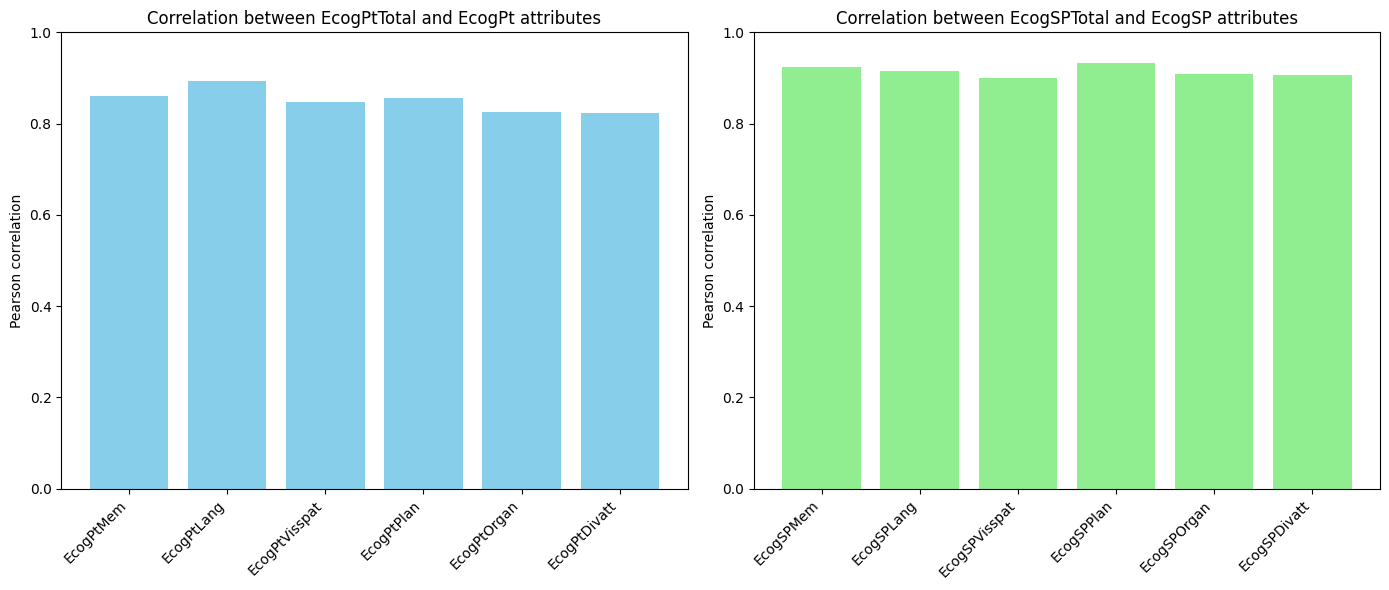

In [19]:
# Columns related to EcogPt and EcogSP scores (excluding the Total columns)
ecogpt_cols = ['EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt']
ecogsp_cols = ['EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt']

# Calculate sum and mean for EcogPt attributes
ecogpt_sum = train[ecogpt_cols].sum(axis=1)
ecogpt_mean = train[ecogpt_cols].mean(axis=1)

# Calculate sum and mean for EcogSP attributes
ecogsp_sum = train[ecogsp_cols].sum(axis=1)
ecogsp_mean = train[ecogsp_cols].mean(axis=1)

# Calculate absolute differences between Total and sum/mean for EcogPtTotal
diff_pt_sum = (ecogpt_sum - train['EcogPtTotal']).abs()
diff_pt_mean = (ecogpt_mean - train['EcogPtTotal']).abs()

# Calculate absolute differences between Total and sum/mean for EcogSPTotal
diff_sp_sum = (ecogsp_sum - train['EcogSPTotal']).abs()
diff_sp_mean = (ecogsp_mean - train['EcogSPTotal']).abs()

# Print max differences to check if Total columns correspond to sum or mean
print("=== EcogPtTotal Analysis ===")
print(f"Max absolute difference between EcogPtTotal and sum of EcogPt components: {diff_pt_sum.max():.6f}")
print(f"Max absolute difference between EcogPtTotal and mean of EcogPt components: {diff_pt_mean.max():.6f}")

print("\n=== EcogSPTotal Analysis ===")
print(f"Max absolute difference between EcogSPTotal and sum of EcogSP components: {diff_sp_sum.max():.6f}")
print(f"Max absolute difference between EcogSPTotal and mean of EcogSP components: {diff_sp_mean.max():.6f}")

# Compute Pearson correlation coefficients between Total and sum for both EcogPt and EcogSP
corr_pt_sum = train['EcogPtTotal'].corr(ecogpt_sum)
corr_sp_sum = train['EcogSPTotal'].corr(ecogsp_sum)

print("\n=== Correlation with sum ===")
print(f"Correlation between EcogPtTotal and sum of EcogPt components: {corr_pt_sum:.4f}")
print(f"Correlation between EcogSPTotal and sum of EcogSP components: {corr_sp_sum:.4f}")

# Compute Pearson correlation coefficients between Total and mean for both EcogPt and EcogSP
corr_pt_mean = train['EcogPtTotal'].corr(ecogpt_mean)
corr_sp_mean = train['EcogSPTotal'].corr(ecogsp_mean)

print("\n=== Correlation with mean ===")
print(f"Correlation between EcogPtTotal and mean of EcogPt components: {corr_pt_mean:.4f}")
print(f"Correlation between EcogSPTotal and mean of EcogSP components: {corr_sp_mean:.4f}")

# Calculate Pearson correlations between EcogPtTotal and individual EcogPt attributes
corrs_pt = {}
for col in ecogpt_cols:
    corr = train['EcogPtTotal'].corr(train[col])
    corrs_pt[col] = corr

# Calculate Pearson correlations between EcogSPTotal and individual EcogSP attributes
corrs_sp = {}
for col in ecogsp_cols:
    corr = train['EcogSPTotal'].corr(train[col])
    corrs_sp[col] = corr

# Print correlations before plotting
print("\nCorrelations between EcogPtTotal and EcogPt attributes:")
for attr, corr_val in corrs_pt.items():
    print(f"{attr}: {corr_val:.4f}")

print("\nCorrelations between EcogSPTotal and EcogSP attributes:")
for attr, corr_val in corrs_sp.items():
    print(f"{attr}: {corr_val:.4f}")

# Plotting correlations as bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for EcogPtTotal correlations
axes[0].bar(corrs_pt.keys(), corrs_pt.values(), color='skyblue')
axes[0].set_ylim(0, 1)
axes[0].set_title('Correlation between EcogPtTotal and EcogPt attributes')
axes[0].set_ylabel('Pearson correlation')
axes[0].set_xticks(range(len(corrs_pt)))
axes[0].set_xticklabels(corrs_pt.keys(), rotation=45, ha='right')

# Bar chart for EcogSPTotal correlations
axes[1].bar(corrs_sp.keys(), corrs_sp.values(), color='lightgreen')
axes[1].set_ylim(0, 1)
axes[1].set_title('Correlation between EcogSPTotal and EcogSP attributes')
axes[1].set_ylabel('Pearson correlation')
axes[1].set_xticks(range(len(corrs_sp)))
axes[1].set_xticklabels(corrs_sp.keys(), rotation=45, ha='right')

print("\n")

plt.tight_layout()
plt.show()

`EcogPtTotal` and `EcogSPTotal` are effectively redundant with their component scores: the totals correlate ≈ 0.996–0.998 with the component mean, while individual components correlate strongly with their respective totals (PT: 0.82–0.90; SP: 0.89–0.94), with SP components slightly tighter. We drop the Total columns and retain the six component variables. 

In [20]:
train.drop(["EcogPtTotal", "EcogSPTotal"], axis=1, inplace=True)

#### Composite Scores (mPACC)

`mPACCdigit` and `mPACCtrailsB` are two modified versions of the Preclinical Alzheimer’s Cognitive Composite (PACC), calculated within the ADNI dataset. In the original version, the PACC combines tests such as FCSRT (*Free and Cued Selective Reminding Test*), Logical Memory II, Digit Symbol Substitution and MMSE, but ADNI does not include FCSRT (which is why it is modified).
- `mPACCdigit` uses the Digit Symbol Substitution Test (`DIGITSCOR`) instead of the FCSRT. It is more sensitive to processing speed and attention.
- `mPACCtrailsB` uses the Trail Making Test Part B (`TRABSCOR`) instead of the FCSRT. It is more sensitive to executive functions and multitasking.

Therefore they are higly similar. We measure the correlation between the two. 

In [21]:
correlation = train["mPACCdigit"].corr(train["mPACCtrailsB"])
print(f"Correlation between mPACCdigit and mPACCtrailsB: \t {correlation}")

Correlation between mPACCdigit and mPACCtrailsB: 	 0.978570266302394


The correlation is very high and therefore the information is practically redundant. We see which one has the bigger mutual information in relation to the **Diagnosis**. 

In [22]:
X = train[["mPACCdigit", "mPACCtrailsB"]]
y = train['DX']  # target 

mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

mPACCdigit      0.646655
mPACCtrailsB    0.593376
dtype: float64


Although they are very close to each other, we prefer to keep `mPACCdigit`. Furthermore we can say that `DIGITSCOR` was removed during data cleaning due to the high percentage of NULL values, while `TRABSCOR` is still present. Therefore, we decided to drop `mPACCtrailsB`.

In [23]:
train.drop(["mPACCtrailsB"], axis=1, inplace=True)

#### `MARRIED`


We want to see how many people are married and how many are not.

In [24]:
print(train["MARRIED"].value_counts())
print(((train["MARRIED"].value_counts(normalize=True) * 100).round(2).astype(str) + '%'))

MARRIED
1    1451
0     483
Name: count, dtype: int64
MARRIED
1    75.03%
0    24.97%
Name: proportion, dtype: object


75% of people are *married*. This attribute is too unbalanced and we assume it isn't very predictive of diagnosis. So we're removing it.

In [25]:
train.drop(["MARRIED"], axis=1, inplace=True)

#### `PTDEMOGROUP`

We want to see the distribution of demographic groups.

In [26]:
print(train["PTDEMOGROUP"].value_counts())
print(((train["PTDEMOGROUP"].value_counts(normalize=True) * 100).round(2).astype(str) + '%'))

PTDEMOGROUP
6    1633
2     149
4      79
1      43
5      23
0       5
3       2
Name: count, dtype: int64
PTDEMOGROUP
6    84.44%
2      7.7%
4     4.08%
1     2.22%
5     1.19%
0     0.26%
3      0.1%
Name: proportion, dtype: object


84% of people are *white*. This attribute is too unbalanced. So we're removing it. It's a shame, because if it had been more heterogeneous we could have seen some interesting patterns.

In [27]:
train.drop(["PTDEMOGROUP"], axis=1, inplace=True)

## Build Dataset with Hybrid Sampling

We have observed that the classes are slightly **unbalanced**.

In [28]:
print("Original class distribution (count):")
print(train['DX'].value_counts())
print("\nOriginal class distribution (percentages):")
print(((train['DX'].value_counts(normalize=True) * 100).round(2).astype(str) + '%'))

Original class distribution (count):
DX
CN      717
LMCI    548
EMCI    336
AD      333
Name: count, dtype: int64

Original class distribution (percentages):
DX
CN      37.07%
LMCI    28.34%
EMCI    17.37%
AD      17.22%
Name: proportion, dtype: object


When there are unbalanced classes, models tend to ignore them (**majority bias**), leading to **low recall** for the minority. To solve this problem we use the **Hybrid Sampling**.

Hybrid Sampling consists of two operations:
- **Random UnderSampling (RUS):** Reduces the majority class by eliminating random observations;
- **Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTENC):** Generates synthetic samples for the minority by interpolating real examples (also handles categorical features).

Hybrid Sampling is useful when you want to improve the representation of minority groups without destroying the information structure of the majority.

In [29]:
# Undersampling strategy: only for classes larger than target_count
undersample_dict = {"CN": 500, "LMCI": 500}

# Oversampling strategy: only for classes smaller than target_count
oversample_dict = {"EMCI": 500, "AD": 500}

categorical_features = [
    train.columns.get_loc("PTGENDER"),
    train.columns.get_loc("APOE4")
]

print("\nUndersample dict (RUS) -> classes to reduce:")
print(undersample_dict)
print("\nOversample dict (SMOTENC) -> classes to increase:")
print(oversample_dict)


Undersample dict (RUS) -> classes to reduce:
{'CN': 500, 'LMCI': 500}

Oversample dict (SMOTENC) -> classes to increase:
{'EMCI': 500, 'AD': 500}


In [30]:
steps = []

rus = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)
steps.append(("rus", rus))

smotenc = SMOTENC(categorical_features=categorical_features, sampling_strategy=oversample_dict, random_state=42)
steps.append(("smotenc", smotenc))

X_train = train.drop(columns=['DX'])
y_train = train['DX']

pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)
sampled = pd.concat([pd.DataFrame(X_res, columns=X_train.columns),
                     pd.DataFrame(y_res, columns=['DX'])],
                    axis=1)
# Shuffling
sampled = sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Distribution after resampling
order = ["CN", "EMCI", "LMCI", "AD"]
print("\nClass distribution after resampling (count):")
print(sampled['DX'].value_counts().reindex(order))
print("\nClass distribution after resampling (percentages):")
print(((sampled['DX'].value_counts(normalize=True) * 100).astype(str) + '%').reindex(order))

display(sampled.describe().T)


Class distribution after resampling (count):
DX
CN      500
EMCI    500
LMCI    500
AD      500
Name: count, dtype: int64

Class distribution after resampling (percentages):
DX
CN      25.0%
EMCI    25.0%
LMCI    25.0%
AD      25.0%
Name: proportion, dtype: object


,count,mean,std,min,25%,50%,75%,max
AGE,2000.0,72.544500,7.245914,53.000000,68.000000,73.000000,78.000000,91.000000
PTGENDER,2000.0,0.501500,0.500123,0.000000,0.000000,1.000000,1.000000,1.000000
PTEDUCAT,2000.0,16.002000,2.780443,4.000000,14.000000,16.000000,18.000000,20.000000
APOE4,2000.0,0.549500,0.643239,0.000000,0.000000,0.000000,1.000000,2.000000
CDRSB,2000.0,1.819250,1.898751,0.000000,0.500000,1.000000,3.000000,10.000000
ADAS13,2000.0,17.426000,9.900128,0.000000,10.000000,16.000000,24.000000,55.000000
MMSE,2000.0,26.870500,2.859689,16.000000,25.000000,28.000000,29.000000,30.000000
RAVLT_immediate,2000.0,34.598000,12.497299,1.000000,25.000000,33.000000,43.000000,70.000000
RAVLT_learning,2000.0,4.118500,2.753225,-4.000000,2.000000,4.000000,6.000000,12.000000
RAVLT_forgetting,2000.0,4.336500,2.431918,-5.000000,3.000000,4.000000,6.000000,14.000000


## Final Dataset after Data Preprocessing

Then this is the dataset given by the Data Preprocessing procedure.

In [31]:
train = train.reindex(columns=['DX', "AGE", "PTGENDER", "PTEDUCAT", "APOE4", "MMSE", "CDRSB", "ADAS13", "LDELTOTAL", "FAQ", "MOCA", "TRABSCOR", "RAVLT_immediate", "RAVLT_learning", "RAVLT_perc_forgetting", "mPACCdigit", "EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan", "EcogPtOrgan", "EcogPtDivatt", "EcogSPMem", "EcogSPLang", "EcogSPVisspat", "EcogSPPlan", "EcogSPOrgan", "EcogSPDivatt", "FDG", "TAU/ABETA", "PTAU/ABETA", "Hippocampus/ICV", "Entorhinal/ICV", "Fusiform/ICV", "MidTemp/ICV", "Ventricles/ICV", "WholeBrain/ICV"])
test = test.reindex(columns=['DX', "AGE", "PTGENDER", "PTEDUCAT", "APOE4", "MMSE", "CDRSB", "ADAS13", "LDELTOTAL", "FAQ", "MOCA", "TRABSCOR", "RAVLT_immediate", "RAVLT_learning", "RAVLT_perc_forgetting", "mPACCdigit", "EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan", "EcogPtOrgan", "EcogPtDivatt", "EcogSPMem", "EcogSPLang", "EcogSPVisspat", "EcogSPPlan", "EcogSPOrgan", "EcogSPDivatt", "FDG", "TAU/ABETA", "PTAU/ABETA", "Hippocampus/ICV", "Entorhinal/ICV", "Fusiform/ICV", "MidTemp/ICV", "Ventricles/ICV", "WholeBrain/ICV"])

train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)

display(train)

,DX,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,TAU/ABETA,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,AD,80,1,14,0,21,6.5,42,0,19,13,300,15,1,100.0000,-20.06920,3.14286,3.000000,3.000000,3.200000,2.500000,2.75,4.000000,3.444440,2.666670,3.000000,3.666670,3.75,1.042620,0.630939,0.061115,0.003517,0.000970,0.009514,0.011188,0.039862,0.680575
1,LMCI,82,1,20,0,24,1.5,20,2,4,20,155,29,0,83.3333,-10.20060,2.10000,1.780554,1.274284,1.373334,1.699998,1.65,2.950000,2.530556,2.014286,1.756666,2.316666,2.75,1.080580,0.421770,0.041719,0.003360,0.001276,0.008863,0.010643,0.049299,0.640478
2,LMCI,71,1,19,0,26,1.0,8,2,2,25,106,51,2,-18.1818,-5.90200,2.75000,2.555560,2.285710,3.200000,3.833330,3.50,1.510714,1.266666,1.438096,1.760000,1.680000,1.85,1.414550,0.182691,0.016757,0.005090,0.002786,0.012161,0.014206,0.025251,0.630110
3,CN,75,0,20,0,30,0.0,6,19,0,26,58,61,7,20.0000,3.19941,1.75000,1.333330,1.000000,1.000000,1.166670,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.118820,0.263255,0.024724,0.004908,0.002758,0.012983,0.013293,0.044823,0.677111
4,CN,81,0,19,0,29,0.0,8,11,0,29,54,54,7,28.5714,-1.16303,1.87500,1.555560,1.000000,1.000000,1.333330,1.75,1.375000,1.111110,1.000000,1.200000,1.166670,1.75,1.270141,0.197315,0.018091,0.004700,0.002912,0.013675,0.016983,0.036393,0.726675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,LMCI,64,0,14,2,27,2.0,22,0,9,22,62,31,1,100.0000,-10.37820,2.97500,1.930556,1.585714,1.400000,1.416668,1.95,3.025000,1.955554,1.671428,1.600000,1.866666,2.35,1.096238,0.709354,0.067789,0.003776,0.001849,0.010658,0.011583,0.019025,0.659038
1930,LMCI,82,1,18,0,28,1.5,23,5,1,25,79,33,1,42.8571,-9.18102,2.12500,1.125000,1.166670,2.000000,2.500000,2.00,2.625000,1.625000,1.166670,1.400000,1.833330,2.00,1.068610,0.263624,0.025132,0.003199,0.001527,0.012497,0.014003,0.030409,0.648833
1931,LMCI,76,1,12,0,25,1.0,16,3,1,22,300,27,2,16.6667,-9.94141,1.60000,1.533332,1.219048,1.040000,1.133334,1.45,2.100000,1.322222,1.657144,1.400000,1.366666,2.05,1.130734,0.175266,0.015387,0.005291,0.002843,0.009460,0.013091,0.019144,0.634472
1932,LMCI,74,1,19,1,26,2.0,27,3,8,21,102,32,1,100.0000,-13.05080,1.87500,1.333330,1.000000,1.200000,1.333330,1.00,3.125000,2.875000,1.857140,1.333330,2.250000,3.25,1.116780,0.673073,0.062445,0.002890,0.001061,0.008794,0.009382,0.040972,0.642200


And this is the dataset given by the Data Preprocessing procedure with sampling.

In [32]:
sampled = sampled.reindex(columns=['DX', "AGE", "PTGENDER", "PTEDUCAT", "APOE4", "MMSE", "CDRSB", "ADAS13", "LDELTOTAL", "FAQ", "MOCA", "TRABSCOR", "RAVLT_immediate", "RAVLT_learning", "RAVLT_perc_forgetting", "mPACCdigit", "EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan", "EcogPtOrgan", "EcogPtDivatt", "EcogSPMem", "EcogSPLang", "EcogSPVisspat", "EcogSPPlan", "EcogSPOrgan", "EcogSPDivatt", "FDG", "TAU/ABETA", "PTAU/ABETA", "Hippocampus/ICV", "Entorhinal/ICV", "Fusiform/ICV", "MidTemp/ICV", "Ventricles/ICV", "WholeBrain/ICV"])

sampled.to_csv('../data/sampled.csv', index=False)

display(sampled)

,DX,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,TAU/ABETA,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,EMCI,78,0,20,0,27,0.5,13,9,0,23,82,32,6,60.680331,-5.999106,2.409017,1.687067,1.038877,1.508853,1.363279,2.658198,1.727050,1.383967,1.103983,1.545574,1.000000,1.476231,1.207387,0.391996,0.033913,0.004632,0.002612,0.012346,0.013350,0.026616,0.696178
1,CN,74,0,16,1,30,0.0,1,17,0,29,94,67,6,0.000000,2.809160,1.625000,1.444442,1.200000,1.200000,1.066666,1.600000,1.150000,1.066666,1.066666,1.080000,1.200000,1.250000,1.355332,0.330964,0.031714,0.005376,0.002775,0.012297,0.013312,0.008794,0.691732
2,LMCI,79,1,14,1,26,1.5,16,2,4,21,65,30,4,71.428600,-7.933560,2.000000,1.755556,1.361906,1.200000,1.433332,1.250000,2.328572,1.877778,2.104760,1.760000,1.876666,2.450000,1.097973,0.502035,0.055375,0.003822,0.002227,0.008753,0.011503,0.023139,0.610266
3,EMCI,70,0,16,0,30,0.5,13,5,0,25,98,38,4,87.500000,-3.140760,2.375000,1.777780,1.142860,1.600000,1.000000,1.250000,1.375000,1.333330,1.142860,1.200000,1.000000,1.250000,1.345940,0.122598,0.010967,0.005470,0.002888,0.012538,0.014535,0.018772,0.702045
4,LMCI,76,1,15,1,26,5.0,28,0,7,20,54,13,3,100.000000,-14.250300,2.500000,2.666670,2.000000,2.000000,2.000000,2.000000,2.250000,2.000000,1.666670,1.400000,2.000000,2.000000,1.072556,0.439187,0.042353,0.003236,0.001600,0.010214,0.010869,0.032258,0.620433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,EMCI,77,0,17,0,29,1.0,14,6,0,20,259,37,7,-36.363600,-4.647250,2.000000,1.444440,1.428570,1.000000,1.333330,1.000000,1.250000,1.111110,1.142860,1.000000,1.000000,1.500000,1.380370,0.303912,0.027509,0.004605,0.002441,0.014253,0.013284,0.019592,0.734359
1996,LMCI,70,1,18,1,30,1.5,9,8,0,26,59,50,9,7.142860,-0.317317,2.450000,2.133334,1.766668,1.480000,2.066668,2.150000,2.025000,1.627780,1.506668,1.750000,1.926666,2.200000,1.172210,0.472523,0.048997,0.004844,0.002562,0.012640,0.014303,0.024570,0.678846
1997,EMCI,71,1,18,0,28,0.5,11,10,5,24,75,41,6,40.000000,-1.984110,2.000000,2.000000,1.166670,1.000000,1.000000,1.000000,2.625000,1.666670,1.666670,2.400000,1.166670,2.250000,1.072410,0.149565,0.013703,0.005109,0.002793,0.012876,0.013422,0.020608,0.701561
1998,LMCI,67,1,18,0,29,1.0,15,6,0,25,63,40,3,75.000000,-6.132330,2.250000,1.888890,1.142860,1.400000,1.666670,3.000000,2.375000,1.888890,1.285710,1.400000,1.333330,2.250000,1.280490,0.135061,0.011992,0.005751,0.002887,0.012528,0.014558,0.015298,0.714705
